
Chapter 2 – End-to-end Machine Learning project

Welcome to Machine Learning Housing Corp.! The goal is to predict median house values in Californian districts, given a number of features from these districts.

<B> Download the Data 

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

Load the data into a dataframe for EDA

In [5]:
import pandas as pd

In [6]:
def load_data(filepath):
    return pd.read_csv(filepath)

In [7]:
housing_data_filepath = os.path.join(HOUSING_PATH,'housing.csv')

In [8]:
housing_df = load_data(housing_data_filepath)

In [9]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Performing basic EDA

In [10]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Observation: The total bedroom column has null values and One categorical variable

What values does the categorical variable hold? And how are the districts distributed?

In [11]:
housing_df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [12]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [13]:
import matplotlib.pyplot as plt

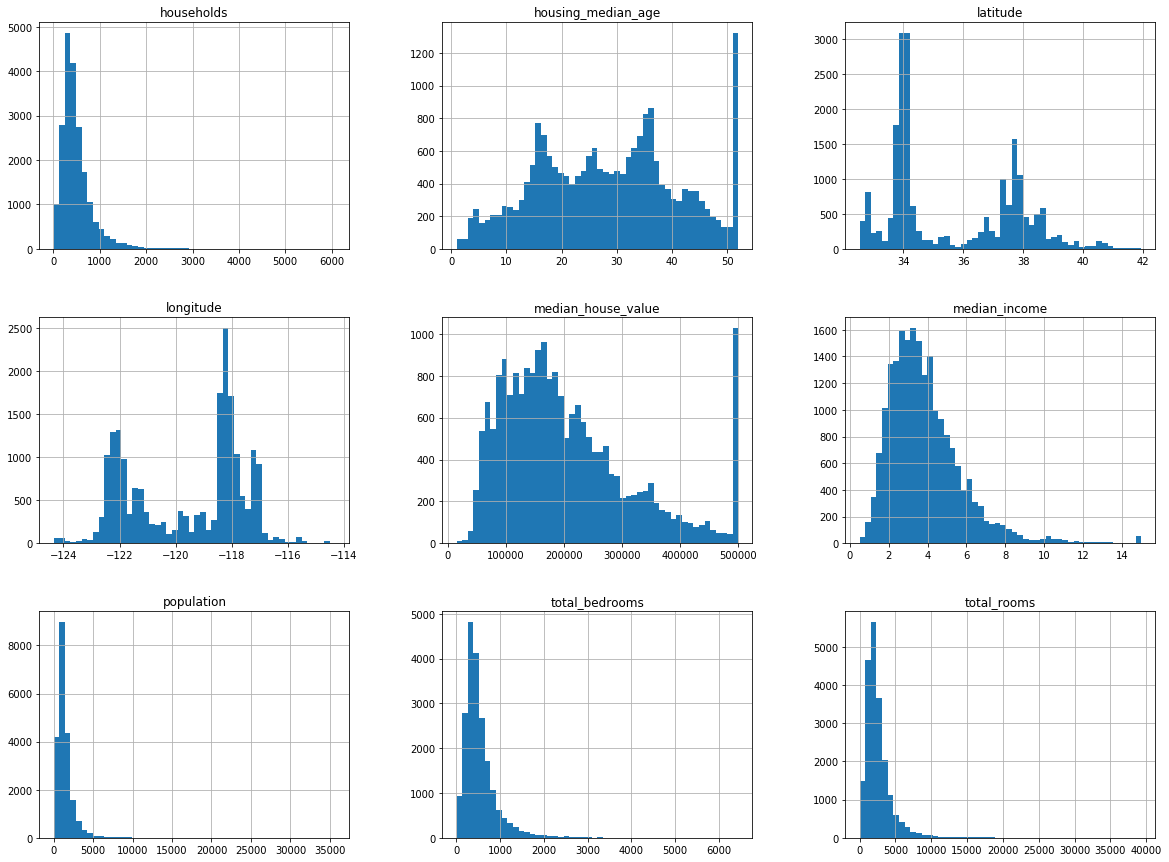

In [14]:
_ =housing_df.hist(bins=50, figsize=(20,15))
plt.show()

<b>Observations: </b>.<br>
1) Most of the distribution is tail-heavy. Right skewed - We need to transform to a normal distribution <br>
2) Medium Income is not in USD. It seems to be scaled and capped <br>
3) Median_house_value and Housing_median_age is also capped. <br>


Spoke to the team to understand if they wanted the capped median house value or the accurate ones. If they wanted accurate ones the data needs to be corrected for the capped values. 

create a test set

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_set, test_set = train_test_split(housing_df,test_size=0.2,random_state=42)

In [17]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


This would just get the train set. Reason : We don't data snopping by looking at the test_set. We shouldn't look at the test set

<B>Stratified Sampling

Inorder to avoid sampling bias, I need to choose a test_set that is representative of the population. Here median_income is a important factor in the determination of the target variable. So we need to get the enough data from each strata of income.

In [18]:
import numpy as np

In [19]:
#create a category column for each income range. divide by and ceil the value
housing_df['income_cat'] = np.ceil(housing_df.median_income/1.5)

In [20]:
housing_df.income_cat[:5]

0    6.0
1    6.0
2    5.0
3    4.0
4    3.0
Name: income_cat, dtype: float64

In [21]:
#Capping to 5 categories
housing_df.income_cat.where(housing_df.income_cat < 5, 5.0, inplace=True)

In [22]:
housing_df.income_cat[:5]

0    5.0
1    5.0
2    5.0
3    4.0
4    3.0
Name: income_cat, dtype: float64

<b>Series.where(cond, other=nan, inplace=False, axis=None, level=None, errors='raise', try_cast=False, raise_on_error=None)</b>
Replace values where the condition is False.

Parameters:	
cond : boolean NDFrame, array-like, or callable
Where cond is True, keep the original value. Where False, replace with corresponding value from other.

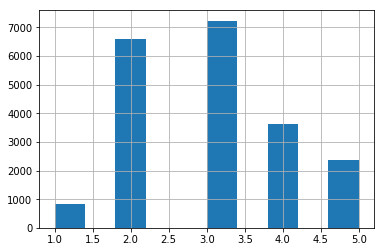

In [23]:
_=housing_df.income_cat.hist()
plt.show()

Using StratifiedShuffleSplit : 
class sklearn.model_selection.StratifiedShuffleSplit(n_splits=10, test_size=’default’, train_size=None, random_state=None)
<br>split(X, y[, groups])	Generate indices to split data into training and test set.
Stratified ShuffleSplit cross-validator

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

In [25]:
splits = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

In [26]:
for train_index,test_index in splits.split(housing_df,housing_df.income_cat):
    strat_train_set = housing_df.loc[train_index]
    strat_test_set = housing_df.loc[test_index]

Checking, If we got in equal propostions of income category

In [27]:
strat_test_set.income_cat.value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Checking distribution in full data

In [28]:
housing_df.income_cat.value_counts()/len(housing_df)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [29]:
# Remove income_cat since it has served 
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

Reason why the test set had to be taken out first: Inorder to avoid data snooping we make sure we take the test set from the sample. The model we fit, would be more generalized and would be not overfit. 

In [30]:
#Exploratory Data Analysis

In [31]:
#Getting the training set to explore
housing_df = strat_train_set.copy()

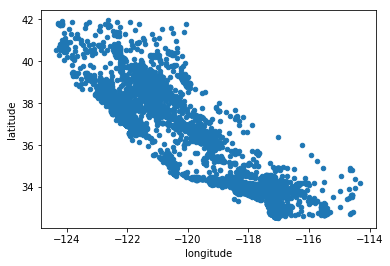

In [32]:
_=housing_df.plot(kind='scatter',x='longitude',y='latitude')
plt.show()

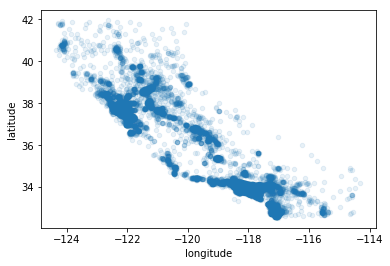

In [33]:
#Hard to see any good pattern in the data
# Use alpha to see the density
_=housing_df.plot(kind='scatter',x='longitude',y='latitude', alpha=0.1)
plt.show()

This show the denser area

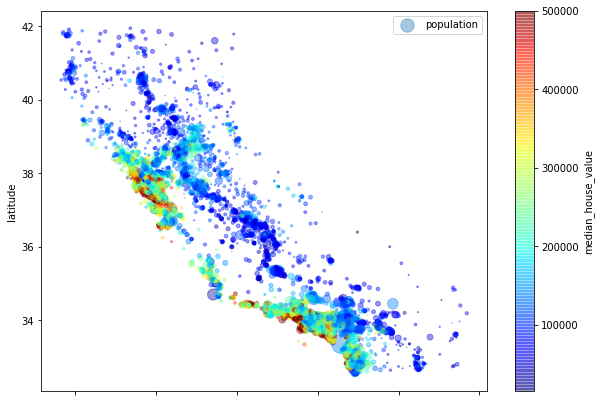

In [34]:
#changing parameters to get a better intution about the data.
housing_df.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=housing_df.population/100,label='population'\
               , figsize=(10,7) , c= 'median_house_value', cmap = plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

<b> Observations: <br> </b>
1) Prices depend on the location - Close to the ocean (Not a straight forward rule since Northern region has lower prices.) <br>
2) Also, the population density

<b>Looking for correlations

In [35]:
import seaborn as sns

In [36]:
corr_matrix = housing_df.corr()

In [37]:
#Checking how each attribute relates with the target varible
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Here, it shows a positive correlation with the median income and a slight negative correlation we up north. 

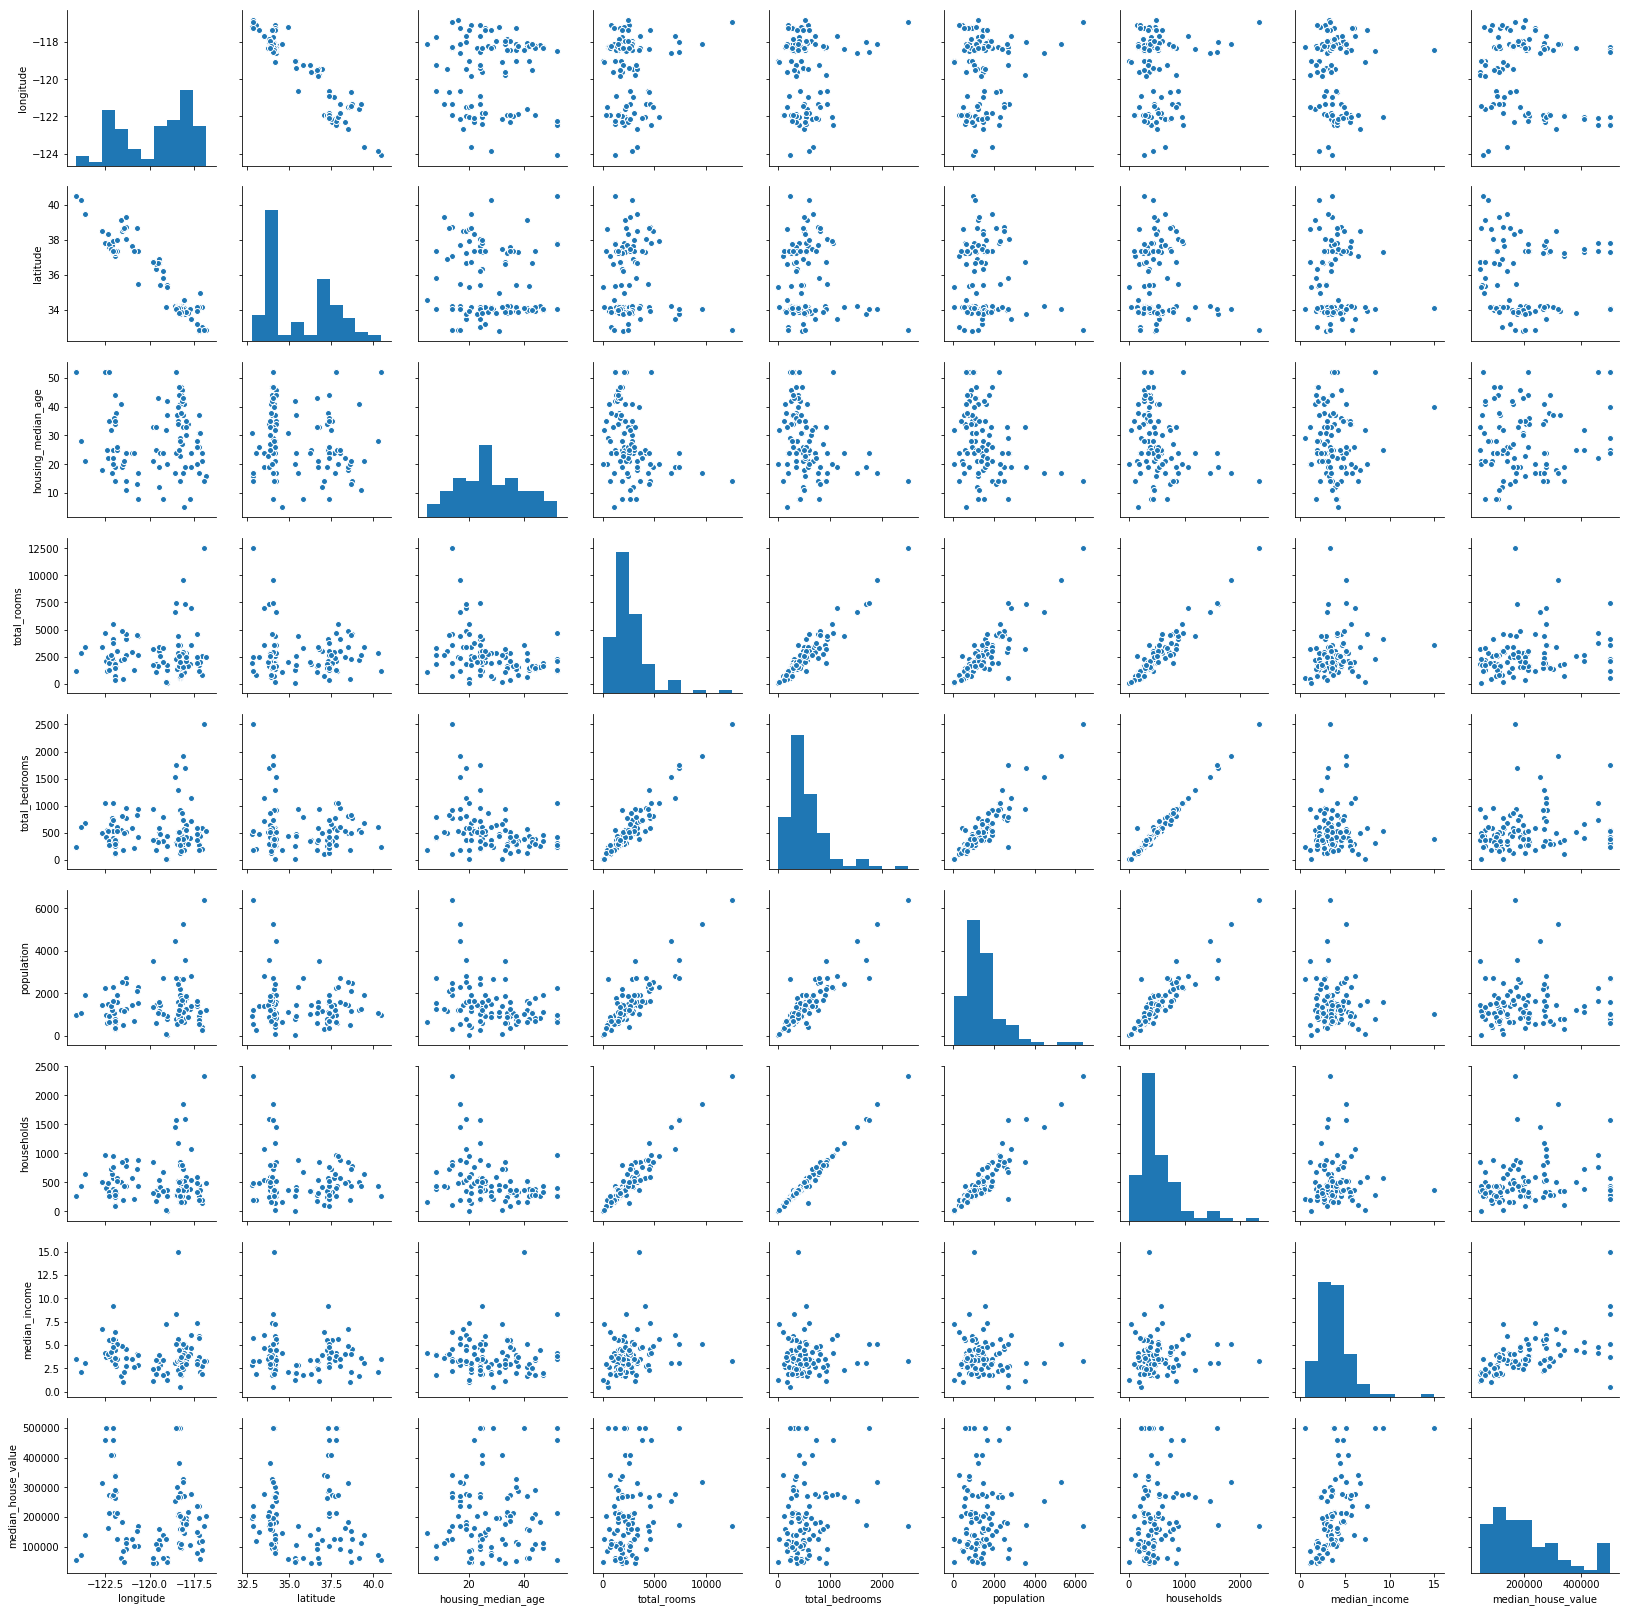

In [38]:
# A pair wise plot works better if the columns are smaller and the data count is small. 
# Similar to scatter matrix. 
sns.pairplot(housing_df[:100])
plt.show()

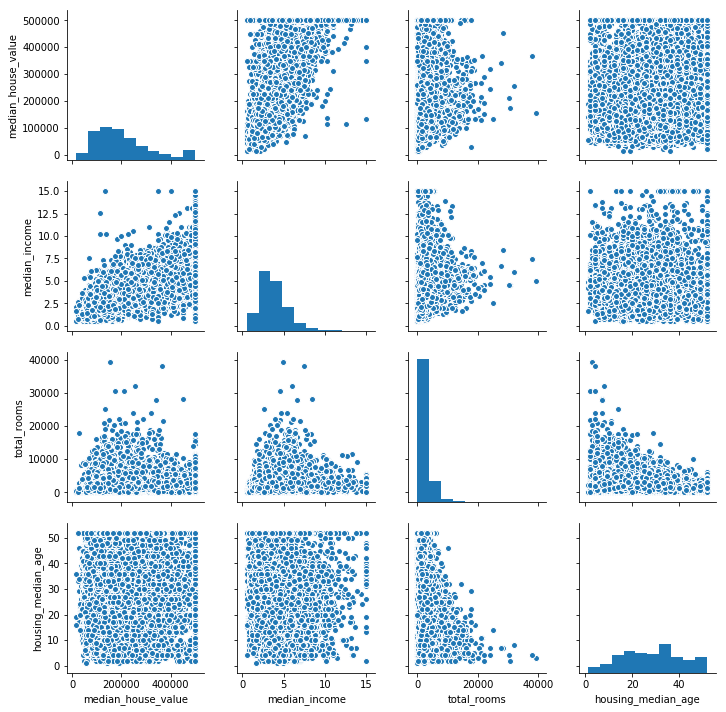

In [39]:
# choosing only the columns of interest. 
attributes = ['median_house_value','median_income','total_rooms','housing_median_age']
_=sns.pairplot(housing_df[attributes])
plt.show()

Median income seems to be correlated to the median house value. I will dive a little deeper to understand it.

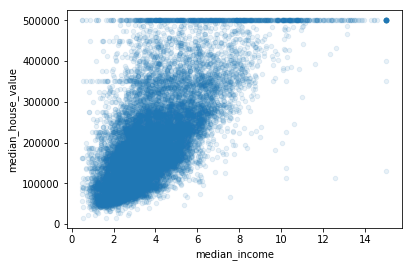

In [40]:
_=housing_df.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)
plt.show()

<b>Observation:</b><br> 
<ol><li>The plot shows a strong correlation. It has upward trend and the data is not too dispersed.</li>
<li> The column data is tail-heavy</li>
<li>The max cap is seen on the top at 500000</li>
<ol><li>Other Sligher horizontal lines are seen at 480k,350k,250k</li></ol></ol>

We need to remove those districts with slight horizontal lines (data quirks)<br>
Also, transform tail-heavy column data

<b><u>Exploration with Attribute Combinations

In [41]:
housing_df['rooms_per_household'] = housing_df.total_rooms / housing_df.households
housing_df['bedrooms_per_room'] = housing_df.total_bedrooms / housing_df.total_rooms
housing_df['population_per_household'] = housing_df.population / housing_df.households

In [42]:
corr_matrix = housing_df.corr()

In [43]:
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

bedrooms_per_room          -0.259984 <br>
rooms_per_household         0.146285 <br>

These engineered features are giving better insights than just the independent ones. 


<B> Preparing the data for Machine Learning Model<br>

<u> Data Cleansing

There are different ways to handle the missing values. Remove those rows, or entire column or replace with an appropriate value computed from the data. Like the mean, median <br>
If we replace the values, then we need to make sure we save the value and replace them in the test set as well.

<b> Best Solution : </b> <br>
Always compute the imputer value for all the numerical columns. Since we might miss some values when we have the live data.

In [44]:
from sklearn.preprocessing import Imputer

In [45]:
imputer = Imputer(strategy='median')

In [46]:
housing_num = housing_df.drop('ocean_proximity',axis=1)

In [47]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [49]:
#This shows the median value of each column
imputer.statistics_

array([ -1.18510000e+02,   3.42600000e+01,   2.90000000e+01,
         2.11950000e+03,   4.33000000e+02,   1.16400000e+03,
         4.08000000e+02,   3.54090000e+00,   1.79500000e+05,
         5.23228423e+00,   2.03031374e-01,   2.81765270e+00])

In [50]:
# Now using the trained imputer we can transform any dataset. This returns an numpy array
X = imputer.transform(housing_num)

In [51]:
#Tranform the array into a dataframe
housing_tr = pd.DataFrame(data=X,columns=housing_num.columns)